## Import Libraries 
---

This is where we import libraries and specify which features are categorical, needs scaling, and will be dropped.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns
from copy import deepcopy
from collections import defaultdict

sns.set()

# Columns with categorical data that needs to be encoded
categorical_cols = ['serve', 'hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'server.is.impact.player', 'outcome', 'gender' , 'previous.hitpoint']

# Columns in the Data That Should Be Scaled
scaled_data = ['rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 
               'player.distance.travelled', 'player.impact.depth', 
               'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 
               'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net', 
               'player.impact.distance.from.center']

# Columns to be dropped
train_dropcols = ['ID', 'gender', 'same.side', 'server.is.impact.player', 
                  'outside.baseline', 'previous.hitpoint', 'hitpoint', 'rally', 'serve', 
                  'outside.sideline', 'player.distance.from.center', 'depth', 
                  'player.distance.from.other.length', 'bw.player.distance.penultimate',
                  'player.distance.from.other.width', 'previous.time.to.net',
                  'player.impact.distance.from.center', 'opponent.distance.from.center', 
                  'player.from.net.penultimate','net.clearance.difference',]

# Columns to be dropped
test_dropcols = ['ID', 'gender', 'same.side', 'server.is.impact.player', 'depth',
                 'outside.baseline', 'previous.hitpoint', 'hitpoint', 'rally', 'serve', 
                 'outside.sideline', 'player.distance.from.center', 'previous.time.to.net',
                 'player.distance.from.other.length', 'player.impact.distance.from.center',
                 'player.distance.from.other.width', 'opponent.distance.from.center', 
                 'player.from.net.penultimate', 'bw.player.distance.penultimate',
                 'net.clearance.difference', ]

######################## Load Data #################
raw_train =  pd.read_csv('train-1542197608821.csv')
raw_test = pd.read_csv("test-1542197608821.csv")
raw_train.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,previous.depth,opponent.depth,opponent.distance.from.center,same.side,previous.hitpoint,previous.time.to.net,server.is.impact.player,outcome,gender,ID
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,0.705435,12.5628,2.0724,True,F,0.445318,False,UE,mens,8644
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,3.856600,12.3544,5.1124,False,B,0.432434,False,FE,mens,1182
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,2.908892,13.8620,1.6564,False,F,0.397538,True,FE,mens,9042
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,0.557554,14.2596,0.1606,True,B,0.671984,True,UE,mens,1222
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,3.945317,11.3658,1.1082,False,F,0.340411,False,W,mens,4085


---
## Feature Engineering Step
Figure out different ways to combine features or to uncover meta-features.

In [84]:
####################### Feature Engineering #################
def feature_engineer(data):
    
    # Speed difference between previous and last shot
    data['speed.difference'] = data['speed'] - data['previous.speed']
    
    # Net clearance difference between previous and last shot
    data['net.clearance.difference'] = data['net.clearance'] - data['previous.net.clearance']
    
    # The actual distance the player was from the sideline
    data['true.distance.from.sideline'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['distance.from.sideline'], 
                                               data['outside.sideline'])]

    # The actual distance the player was from the baseline
    data['true.distance.from.baseline'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['depth'], 
                                               data['outside.baseline'])]

    # Opponent distance to net + player distance to net
    data['player.distance.from.other.length'] = data['player.depth'] + data['opponent.depth']

    # Opponent distance from center + player distance to center
    data['player.distance.from.other.width'] = [math.fabs(p_center - o_center)
                                                     if boolean else p_center + o_center
                                                     for p_center, o_center, boolean in 
                                                     zip(data['player.distance.from.center'], 
                                                         data['opponent.distance.from.center'], 
                                                         data['same.side'])]

    # Straight line distance between players
    data['bw.player.distance.penultimate'] = [math.hypot(length, width)
                                                 for length, width in 
                                                 zip(data['player.distance.from.other.length'], 
                                                     data['player.distance.from.other.width'])]

    # Distance penultimate shot was made from net- previous to net (s) * penultimate shot (m/s)
    data['player.from.net.penultimate'] = data['previous.speed'] * data['previous.time.to.net']
    
    return data
 
# Perform Feature Engineering
tennis_train = feature_engineer(raw_train)
tennis_test = feature_engineer(raw_test)

tennis_train.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,gender,ID,speed.difference,net.clearance.difference,true.distance.from.sideline,true.distance.from.baseline,player.distance.from.other.length,player.distance.from.other.width,bw.player.distance.penultimate,player.from.net.penultimate
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,mens,8644,3.201450,-1.372257,3.474766,6.797621,26.2332,1.8394,26.297608,14.389823
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,mens,1182,-0.678148,0.353704,2.540801,-2.608708,24.9902,7.4286,26.070945,14.729042
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,mens,9042,-17.489938,-0.631778,3.533166,9.435749,27.5616,3.7472,27.815163,15.824638
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,mens,1222,11.818491,-0.472339,-0.586885,3.342180,27.4088,0.1418,27.409167,16.812251
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,mens,4085,-1.246771,-0.049569,0.918725,5.499119,25.4968,1.4232,25.536490,12.524057


---
## Feature Encoding Step
Categorical data cannot be put directly into the XGBoost model. We have to one-hot encode the data so the model can interpret. e.g. (Blue, Red) -> (0,1)

In [85]:
##################### Encode Categorical Data ################        
for ft in categorical_cols:
    le = LabelEncoder()
    tennis_train[ft] = le.fit_transform(tennis_train[ft])
    if ft == 'outcome':
        break
    else :
        tennis_test[ft] = le.fit_transform(tennis_test[ft])
test_ids = tennis_test['ID']

# Drop the unecessary features
tennis_train = tennis_train.drop(train_dropcols, axis=1) 
tennis_test = tennis_test.drop(test_dropcols, axis=1)

In [86]:
tennis_train.head()

,speed,net.clearance,distance.from.sideline,player.distance.travelled,player.impact.depth,player.depth,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,outcome,speed.difference,true.distance.from.sideline,true.distance.from.baseline
0,35.515042,-0.021725,3.474766,1.467570,14.1758,13.6704,32.313592,1.350533,2.449182,0.705435,12.5628,1,3.201450,3.474766,6.797621
1,33.382640,1.114202,2.540801,2.311931,12.7396,12.6358,34.060788,0.760499,0.583291,3.856600,12.3544,0,-0.678148,2.540801,-2.608708
2,22.316690,-0.254046,3.533166,3.903728,15.3782,13.6996,39.806628,0.377732,1.115250,2.908892,13.8620,0,-17.489938,3.533166,9.435749
3,36.837309,0.766694,0.586885,0.583745,13.7308,13.1492,25.018818,1.239033,3.256695,0.557554,14.2596,1,11.818491,-0.586885,3.342180
4,35.544208,0.116162,0.918725,2.333456,15.1992,14.1310,36.790979,0.165731,1.431146,3.945317,11.3658,2,-1.246771,0.918725,5.499119


---
## Split Data Into Inputs (X) and Outputs (Y)

We need to specify which features are descriptive features (X) and which ones are the target features (Y).

In [87]:
# Split into inputs and output 
tennis_train_X = tennis_train.loc[:, tennis_train.columns != 'outcome']
tennis_train_y = tennis_train['outcome']

---

## Cross Validation and Confusion Matrix
Using the XGBoost model, we perform cross validation (4x) and output the confusion matrix to see which examples the model is misclassifying.

In [96]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


tennis_xgb_model = XGBClassifier(n_estimators=200, random_state= 1, learning_rate= 0.1, 
                               subsample= 0.9, colsample_bytree= 1.0, 
                               eval_metric= 'merror', max_depth= 6, 
                               min_child_weight= 1, gamma= 0)

y_pred = cross_val_predict(tennis_xgb_model, tennis_train_X, tennis_train_y,cv=5)
confusion_matrix(tennis_train_y,y_pred)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

array([[1342,  411,   65],
       [ 316, 3065,  120],
       [  51,   67, 2564]], dtype=int64)

---
## Checking the Cross Validation Scores

We cross validate the models here and output accuracy and log loss. Log loss is the metric the competition is using, so that's what we will be focusing on.

In [97]:
from sklearn.model_selection import cross_val_score

CV = 5

###### Model #######
# tennis_xgb_model = XGBClassifier(n_estimators=100, random_state= 1, learning_rate= 0.1, 
#                                subsample= 0.9, colsample_bytree= 1.0, max_depth= 5, 
#                                eval_metric= 'merror', min_child_weight= 1)

m_acc = cross_val_score(tennis_xgb_model, tennis_train_X, tennis_train_y, 
                        scoring='accuracy', cv = CV, n_jobs=-1)


print("Number of k-folds: " + str(CV))
print("---------------------------------")

print("Tennis Model Results")
print("Accuracy: {:.4%}".format(np.mean(m_acc)))
print("---------------------------------")

Number of k-folds: 5
---------------------------------
Men's Model Results
Accuracy: 87.1265%
Log Loss: -0.3429430885301096
---------------------------------


---
## Feature Selection

We can determine which features are important by building the model and then checking its "feature importances" attribute.

We will need to create new training data by splitting the training data into a training and validation set. We can use sklearn's train_test_split function. 

Those will low importance can be removed from consideration in the future (already removed below).


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 87.3204%
Log Loss: 0.32241560328172414
----------------
('speed', 0.031325303)
('net.clearance', 0.1460241)
('distance.from.sideline', 0.032771084)
('player.distance.travelled', 0.05879518)
('player.impact.depth', 0.05012048)
('player.depth', 0.041445784)
('previous.speed', 0.08674699)
('previous.net.clearance', 0.067951806)
('previous.distance.from.sideline', 0.07325301)
('previous.depth', 0.06650602)
('opponent.depth', 0.097831324)
('speed.difference', 0.07807229)
('true.distance.from.sideline', 0.07277109)
('true.distance.from.baseline', 0.09638554)


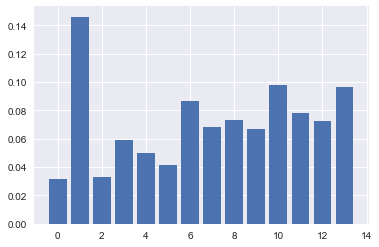

In [90]:
# Create new training and validation set using scikit's train_test_split
tennis_train_XX, val_tennis_XX = train_test_split(tennis_train, test_size=0.2, shuffle=True)
tennis_X_train = tennis_train_XX.loc[:, tennis_train_XX.columns != 'outcome']
tennis_y_train = tennis_train_XX['outcome']
tennis_X_val = val_tennis_XX.loc[:, val_tennis_XX.columns != 'outcome']
tennis_y_val = val_tennis_XX['outcome']

tennis_model = XGBClassifier(eval_metric='merror')
tennis_model.fit(tennis_X_train, tennis_y_train)
tennis_y_prob_pred = tennis_model.predict_proba(tennis_X_val)
tennis_y_pred = tennis_model.predict(tennis_X_val)
tennis_loss = log_loss(tennis_y_val, tennis_y_prob_pred)
tennis_acc = accuracy_score(tennis_y_val, tennis_y_pred)
print("Accuracy: {:.4%}".format(tennis_acc))
print("Log Loss: {}".format(tennis_loss))
print('----------------')

for x in zip(tennis_X_train,tennis_model.feature_importances_):
    print(x)

plt.bar(range(len(tennis_model.feature_importances_)), tennis_model.feature_importances_)
plt.show()


---
## Model/Paramter Tuning

In order to optimze our model, we should tune the hyperparameters.

We can use sklearn's GridSearchCV. It essentially iterates over several paramter values and finds the best one. However, this is pretty computatationally expensive.

Alternatively, we could use sklearn's RandomizedSearchCV, which should provide similar results with less computational expense.

In [128]:
from sklearn.model_selection import GridSearchCV

# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.0001, 0.001, 0.01, 0.1]

cv_params = {'learning_rate': [0.1],'n_estimators': np.arange(200,280,10).tolist()}
ind_params = {'seed':0,  'subsample': 0.6, 'colsample_bytree':1.0,
              'objective': 'multi:softmax', 'max_depth': 6, 'min_child_weight': 1,'min_samples_leaf': 20 }
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                             cv_params, scoring = 'accuracy', cv = 10, n_jobs = -1, verbose=3) 

optimized_GBM.fit(tennis_train_X, tennis_train_y)
print('Optimzed Scores')
optimized_GBM.grid_scores_

print('Accuracy')
optimized_GBM.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 13.7min finished


Optimzed Scores
Accuracy


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.8731408573928259

In [129]:
tennis_test_pred = optimized_GBM.predict(tennis_test)

tennis_test_pred

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([2, 1, 0, ..., 1, 1, 2], dtype=int64)

---
## Training and Fitting the Model

After counltess hours of feature engineering/selecting and hyperparameter tuning, we can finally train the model with the right parameters and data.

In [130]:
# Train Model and Make Predictions
# tennis_model = XGBClassifier(n_estimators=100, seed= 0, learning_rate= 0.1, subsample= 0.9, 
#                                colsample_bytree= 0.8, eval_metric= 'merror', max_depth= 5, 
#                                min_child_weight= 1, gamma= 0)

# tennis_model.fit(tennis_train_X, tennis_train_y)
# tennis_test_pred = tennis_model.predict(tennis_test)

# tennis_test_pred


---
## Formatting Submission

We now need to format the data the way the competition wants us to.

In [131]:
outcome_list = []
for i in range(0, len(tennis_test_pred)):
#     import pdb
#     pdb.set_trace()
    if tennis_test_pred[i] == 0:
        outcome_list.append('FE')
    elif tennis_test_pred[i] ==1:
        outcome_list.append('UE')
    else:
        outcome_list.append('W')


In [132]:
submission =pd.DataFrame(outcome_list, index=test_ids)
submission.columns = ['outcome']

In [133]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
submission.to_csv('Submissions/gradientboost'+timestr+ '.csv')